In [1]:
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Test of the Poisson equation with known solution

In [12]:
n = 127
A = gallery.poisson((n, n))

In [14]:
linear_gmg = gmg_linear.LinearGMG(A, max_levels=4)
print(linear_gmg)
print("Spectral radius = {}".format(linear_gmg.compute_rho()))

Dimension of matrix A for levels:
Level = 0, dimension = (15, 15)
Level = 1, dimension = (31, 31)
Level = 2, dimension = (63, 63)
Level = 3, dimension = (127, 127)

Spectral radius = 0.19741190586548468


(128,)
(127, 127)
(16129, 1)
(16129, 1)
2.05446567233e-11
5.02009159216e-05


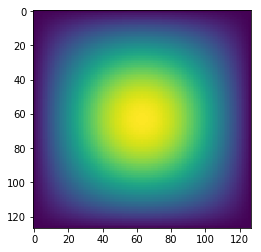

In [4]:
x0 = np.random.randn(A.shape)
x = np.linspace(0, 1, num=n+1, endpoint=False)
y = np.linspace(0, 1, num=n+1, endpoint=False)
print(x.shape)
xx, yy = np.meshgrid(x[1:], y[1:])
print(xx.shape)
x_true = np.sin(np.pi * xx) * np.sin(np.pi * yy)
rhs = 2 * np.pi**2 * x_true / (n+1)**2
plt.imshow(rhs)
rhs = rhs.reshape(A.shape, 1)
print(rhs.shape)
x = linear_gmg.solve(rhs, x0, tol=1e-10)
print(x.shape)
print(np.linalg.norm(A.dot(x) - rhs))
print(np.linalg.norm(x - x_true.reshape(A.shape, 1)) / np.linalg.norm(x_true.reshape(A.shape, 1)))

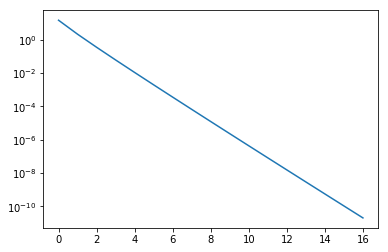

In [5]:
plt.semilogy(linear_gmg.get_gmg_convergence())

In [6]:
x = x.reshape(A.dim)
print(x.shape)

(127, 127)


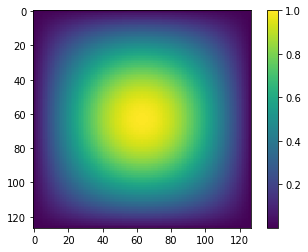

In [7]:
plt.imshow(x)
plt.colorbar()

## Study dependance $\rho$ on dimension in 1D and 2D case and optimize it

### 1D

In [8]:
num_levels = 2
ns = [2**i - 1 for i in range(3, 8)]
rhos_linear = []
print("Test dims: {}".format(ns))
for n in ns:
    print("Current dim = {}".format(n))
    A = gallery.poisson((n, ))
    linear_gmg = gmg_linear.LinearGMG(A, max_levels=num_levels)
    rhos_linear.append(linear_gmg.compute_rho())

Test dims: [7, 15, 31, 63, 127]
Current dim = 7
Current dim = 15
Current dim = 31
Current dim = 63
Current dim = 127


Text(0,0.5,'Spectral radius')

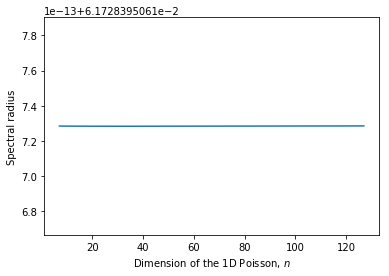

In [9]:
plt.plot(ns, rhos_linear)
plt.xlabel("Dimension of the 1D Poisson, $n$")
plt.ylabel("Spectral radius")

In [10]:
rhos_opt = []
K = 20
batch_size = 10
num_iter = 2500
step_size = 5e-5
PR_stencil_type = "3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
for n in ns:
    print("Current dim = {}".format(n))
    A = gallery.poisson((n, ))
    deep_gmm = dgmg.DeepMG(A, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
    opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)
    opt_par_n[n] = opt_par
    convergence[n] = deep_gmm.get_optimizer_convergence()
    conv_time[n] = deep_gmm.get_optimization_time()
    deep_gmm.update_prd(opt_par)
    current_rho = deep_gmm.compute_rho()
    rhos_opt.append(current_rho)
    print("Optimized rho = {}".format(current_rho))

Current dim = 7
Iteration 100/2500
Upper bound estimation = 0.05498483747839665
Iteration 200/2500
Upper bound estimation = 0.04783896219860398
Iteration 300/2500
Upper bound estimation = 0.040960952236776024
Iteration 400/2500
Upper bound estimation = 0.03418850451859482
Iteration 500/2500
Upper bound estimation = 0.02888609477786421
Iteration 600/2500
Upper bound estimation = 0.026570365794934603
Iteration 700/2500
Upper bound estimation = 0.0252802789408949
Iteration 800/2500
Upper bound estimation = 0.024324560172426894
Iteration 900/2500
Upper bound estimation = 0.02362568536401822
Iteration 1000/2500
Upper bound estimation = 0.02258014554357622
Iteration 1100/2500
Upper bound estimation = 0.021899491905042624
Iteration 1200/2500
Upper bound estimation = 0.02101467405222576
Iteration 1300/2500
Upper bound estimation = 0.020058076431578895
Iteration 1400/2500
Upper bound estimation = 0.01926639731764146
Iteration 1500/2500
Upper bound estimation = 0.018356076534202362
Iteration 160

Iteration 2400/2500
Upper bound estimation = 0.03155099083680839
Iteration 2500/2500
Upper bound estimation = 0.035384012100412816
Optimized rho = 0.033789882130446446


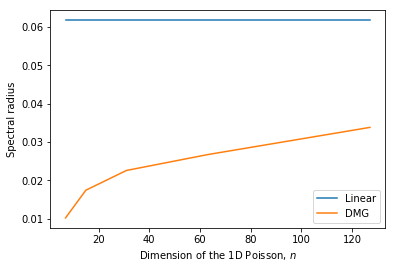

In [11]:
plt.plot(ns, rhos_linear, label="Linear")
plt.plot(ns, rhos_opt, label="DMG")
plt.xlabel("Dimension of the 1D Poisson, $n$")
plt.ylabel("Spectral radius")
plt.legend()

### 2D

In [14]:
num_levels = 4
ns = [2**i - 1 for i in range(3, 8)]
rhos_linear = []
rhos_amg = []
print("Test dims: {}".format(ns))
for n in ns:
    print("Current dim = {}".format(n))
    A = gallery.poisson((n, n))
    linear_gmm = gmg_linear.LinearGMG(A, max_levels=num_levels)
    current_rho = linear_gmm.compute_rho()
    print("Linear spectral radius = {}".format(current_rho))
    rhos_linear.append(current_rho)
    amg = classical_amg.ClassicalAMG(A, num_levels)
    current_rho = amg.compute_rho()
    print("AMG spectral radius = {}".format(current_rho))
    rhos_amg.append(current_rho)

Test dims: [7, 15, 31, 63, 127]
Current dim = 7
Linear spectral radius = 0.16913227029749436
AMG spectral radius = 0.09117489460224773
Current dim = 15
Linear spectral radius = 0.1900485590933702
AMG spectral radius = 0.10991720305651478
Current dim = 31
Linear spectral radius = 0.1956353931532445
AMG spectral radius = 0.123741721830234
Current dim = 63
Linear spectral radius = 0.1970554247753587
AMG spectral radius = 0.16366864639939477
Current dim = 127
Linear spectral radius = 0.1974119058654843
AMG spectral radius = 0.26354464738686534


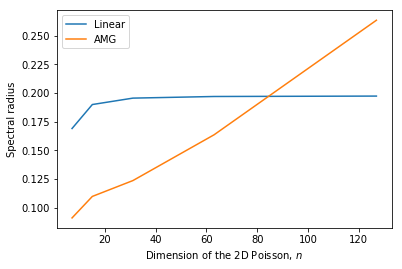

In [15]:
plt.plot(ns, rhos_linear, label="Linear")
plt.plot(ns, rhos_amg, label="AMG")
plt.xlabel("Dimension of the 2D Poisson, $n$")
plt.ylabel("Spectral radius")
plt.legend()

In [19]:
rhos_opt = []
K = 10
batch_size = 30
num_iter = 2000
step_size = 1e-4
PR_stencil_type = "9p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
for n in ns:
    print("Current dim = {}".format(n))
    A = gallery.poisson((n, n))
    gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
    opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)
    opt_par_n[n] = opt_par
    convergence[n] = gmm.get_optimizer_convergence()
    conv_time[n] = gmm.get_optimization_time()
    gmm.update_prd(opt_par)
    current_rho = gmm.compute_rho()
    rhos_opt.append(current_rho)
    print("Optimized rho = {}".format(current_rho))
if init_point:
    init_type = "random"
else:
    init_type = "linear"

Current dim = 7
Dimension of matrix A for levels:
Level = 0, dimension = (1, 1)
Level = 1, dimension = (3, 3)
Level = 2, dimension = (7, 7)

Iteration 100/2000
Upper bound estimation = 0.17111403439950215
Iteration 200/2000
Upper bound estimation = 0.16557343973282126
Iteration 300/2000
Upper bound estimation = 0.15597631003196452
Iteration 400/2000
Upper bound estimation = 0.15483861396120066
Iteration 500/2000
Upper bound estimation = 0.1472071303402176
Iteration 600/2000
Upper bound estimation = 0.1398662123664813
Iteration 700/2000
Upper bound estimation = 0.13142021528750225
Iteration 800/2000
Upper bound estimation = 0.12777818121446433
Iteration 900/2000
Upper bound estimation = 0.1093069922241443
Iteration 1000/2000
Upper bound estimation = 0.0962772057734996
Iteration 1100/2000
Upper bound estimation = 0.08633560224228748
Iteration 1200/2000
Upper bound estimation = 0.07989332371482415
Iteration 1300/2000
Upper bound estimation = 0.07831868660143992
Iteration 1400/2000
Upper b

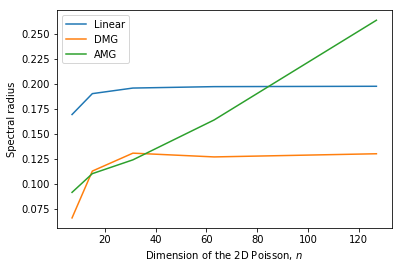

In [20]:
plt.plot(ns, rhos_linear, label="Linear")
plt.plot(ns, rhos_opt, label="DMG")
plt.plot(ns, rhos_amg, label="AMG")
plt.xlabel("Dimension of the 2D Poisson, $n$")
plt.ylabel("Spectral radius")
plt.legend()